In [9]:
import numpy as np

import metpy.calc as mpcalc
from metpy.units import units
from metpy.plots import current_weather, sky_cover, StationPlot, simple_layout, wx_code_to_numeric
from metpy.io import metar

import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [10]:
filename = "20221212_1200"
data = Dataset(filename)

In [11]:
stationName = data.variables['stationName'][:]
latitude = data.variables['latitude'][:]
longitude = data.variables['longitude'][:]
temp = (data.variables['temperature'][:]-273.15)*(9/5)+32.0
dwpt = (data.variables['dewpoint'][:]-273.15)*(9/5)+32.0
wspd = data.variables['windSpeed'][:]
wdir = data.variables['windDir'][:]
gust = data.variables['windGust'][:]
weather =  data.variables['presWeather'][:]
vis = data.variables['visibility'][:]
pslp = data.variables['seaLevelPress'][:]/100
skycover = data.variables['skyCover'][:]

In [12]:
stnNames = ['']*len(stationName)
for index in range(len(stationName)):
    stn = stationName[index].tobytes().decode().rstrip('\x00')
    stnNames[index] = stn
#print(stnNames)

curWx = ['']*len(weather)
for index in range(len(weather)):
    wx = weather[index].tobytes().decode().rstrip('\x00')
    curWx[index] = wx

wxCodes = wx_code_to_numeric(curWx)
#for i in range(len(wxCodes)):
#    print(curWx[i],wxCodes[i])

sky_cover_num = np.empty(len(skycover),dtype=int)
for i in range(len(skycover)):
    this_skycvr = skycover[i].tobytes().decode().rstrip('\x00')
    
    if this_skycvr[-3:] == 'SKC' or this_skycvr[-3:] == 'CLR':
        sky_cover_num[i] = 0
    elif this_skycvr[-3:] == 'FEW':
        sky_cover_num[i] = 2
    elif this_skycvr[-3:] == 'SCT':
        sky_cover_num[i] = 4
    elif this_skycvr[-3:] == 'BKN':
        sky_cover_num[i] = 6
    elif this_skycvr[-3:] == 'OVC':
        sky_cover_num[i] = 8
    else:
        sky_cover_num[i] = 10
        
wdir = np.array(wdir)*units('degrees')
wspd = np.array(wspd)*units('m/s')
u, v = mpcalc.wind_components(wspd,wdir)
print(wdir)


[30.0 350.0 270.0 ... 130.0 0.0 310.0] degree


/tmp/ipykernel_107075/1632888334.py:35: UserWarning: Input over 12.566370614359172 radians. Ensure proper units are given.
  u, v = mpcalc.wind_components(wspd,wdir)


In [21]:
dataForDataFrame = {'station_id':stnNames,
                    'latitude':latitude,
                    'longitude':longitude,
                    'wind_direction':wdir,
                    'wind_speed':wspd,
                    'wind_gust':gust,
                    'visibility':vis,
                    'current_wx1_symbol':wxCodes,
                    'air_temperature':temp,
                    'dew_point_temperature':dwpt,
                    'air_pressure_at_sea_level':pslp,
                    'eastward_wind':u,
                    'northward_wind':v,
                    'cloud_coverage': sky_cover_num}
#colNames = ['station_id', 'latitude', 'longitude', 'wind_direction', 'wind_speed', 'wind_gust' 'visibility', 'current_wx1_symbol', 'air_temperature', 'dew_point_temperature', 'air_pressure_at_sea_level']
data = pd.DataFrame(dataForDataFrame,index=stnNames)
'''data = data[data.wind_direction <= 360]
data = data[data.air_temperature <= 350]
data = data[data.air_temperature >= 180]'''

print(data.wind_direction)



NZCM     30.0
NZWD    350.0
SAWH    270.0
SAWE    270.0
SAVC    270.0
        ...  
KHIE      0.0
KBTV    360.0
CZUM    130.0
KOCW      0.0
CWFW    310.0
Name: wind_direction, Length: 8601, dtype: float32


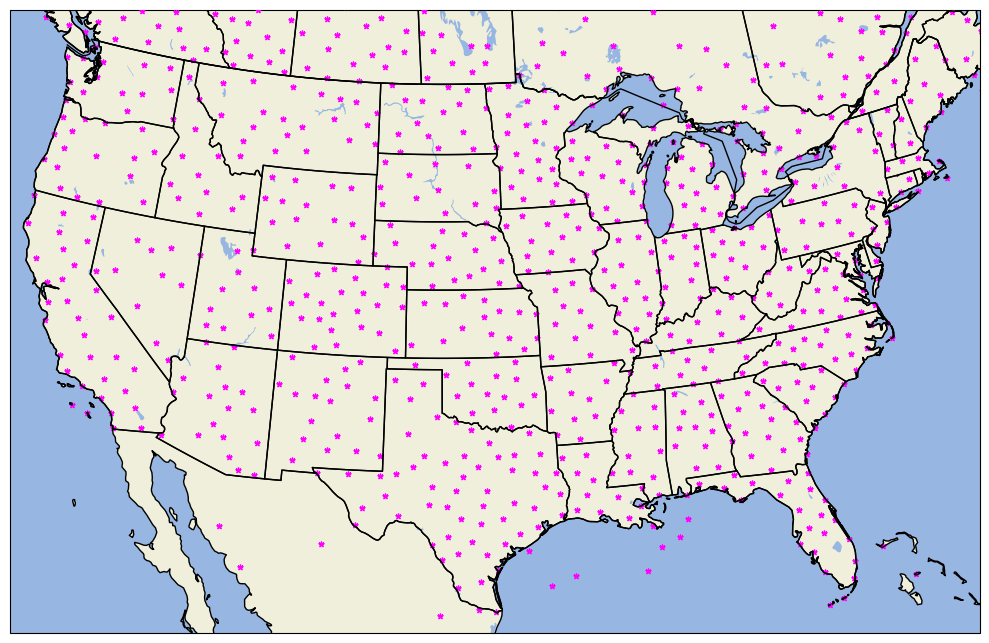

In [22]:
#first convert the lat/lon to map projection coordinates
locs = proj.transform_points(ccrs.PlateCarree(),data['longitude'].values,data['latitude'].values)

#now thin the data
data_thinned = data[mpcalc.reduce_point_density(locs,75*units('km'))]

#map projection jusing a Lambert Conformaeastl Projection
#we'll center the map at 100W,35N
proj = ccrs.LambertConformal(central_longitude=-100,central_latitude=35)

#create 10" x 10" figure with a dpi=100
fig = plt.figure(figsize=(10,10),dpi=100)

#add subplot with projection
ax = fig.add_subplot(1,1,1,projection=proj)

#add elements to make map more useable
ax.add_feature(cfeature.LAND,zorder=1)
ax.add_feature(cfeature.OCEAN,zorder=0)
ax.add_feature(cfeature.LAKES,zorder=2)
ax.add_feature(cfeature.COASTLINE,zorder=10)
ax.add_feature(cfeature.STATES,zorder=10)
ax.add_feature(cfeature.BORDERS,zorder=10)

#zoom on the CONUS
#lon_min = -120
#lon_max = -75
#lat_min = 23
#lat_max = 50
ax.set_extent((-120, -75, 23, 50))

#plot surface obs using scatter plot
plt.scatter(data_thinned.longitude,data_thinned.latitude,color='magenta',marker='*',s=15,transform=ccrs.PlateCarree(),zorder=9)

fig.tight_layout()

plt.savefig("obs_locations_thinned.png",bbox_inches='tight')